# IteraPath Visualization: Orthosporin Case Study

This notebook visualizes the iPKS pathway design results for Orthosporin, including:
1. **Reaction Center (RC) visualization** - Each step's chemical transformation
2. **Pathway graph** - Complete route from acetyl to core scaffold
3. **Domain timeline** - Gate activity (KS/AT/KR/DH/PT/TE)
4. **Molecular structure comparison** - Target vs. template core

---

## Setup & Imports

In [2]:
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx
from rdkit import Chem
from rdkit.Chem import Draw, AllChem, DataStructs
from rdkit.Chem.Draw import SimilarityMaps

# SynKit imports (if available)
try:
    from synkit.IO import rsmi_to_its
    from synkit.Vis import GraphVisualizer
    SYNKIT_AVAILABLE = True
except ImportError:
    print("⚠️ SynKit not available. Skipping ITS/GML visualizations.")
    SYNKIT_AVAILABLE = False

# Paths
ROUTE_JSON = Path("cases/orthosporin/route.json")
GENE_SPEC_JSON = Path("cases/orthosporin/gene_spec.json")
RULES_DIR = Path("3_templates/data/rules")
OUTPUT_DIR = Path("cases/orthosporin/visualizations")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Load data
with open(ROUTE_JSON) as f:
    route = json.load(f)
    
with open(GENE_SPEC_JSON) as f:
    gene_spec = json.load(f)

print(f"✅ Loaded route: {route['bgc_id']} ({len(route['steps'])} steps)")
print(f"✅ Required domains: {', '.join(gene_spec['required_domains'])}")
print(f"✅ Output directory: {OUTPUT_DIR.resolve()}")

✅ Loaded route: BGC1000006 (6 steps)
✅ Required domains: AT, DH, KR, KS, PT, TE
✅ Output directory: C:\syntemp_attempt2\cases\orthosporin\visualizations


## 1. Molecular Structures: Target vs Template Core

✅ Saved: cases\orthosporin\visualizations\01_target_vs_core.png


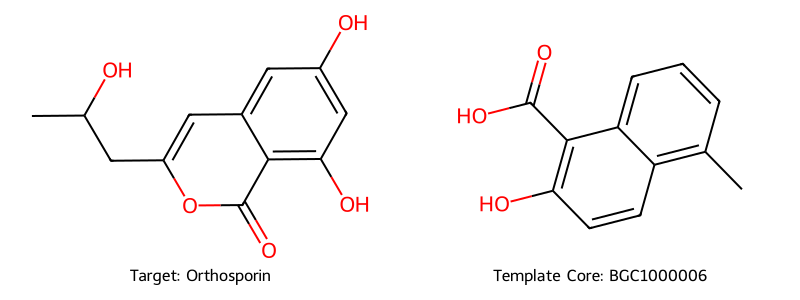

In [3]:
# Compare target vs template core
target_smi = route["target"]
core_smi = route["selector_metrics"]["core_smiles"]

target_mol = Chem.MolFromSmiles(target_smi)
core_mol = Chem.MolFromSmiles(core_smi)

# Generate 2D coordinates for better visualization
AllChem.Compute2DCoords(target_mol)
AllChem.Compute2DCoords(core_mol)

# Draw side by side
img = Draw.MolsToGridImage(
    [target_mol, core_mol],
    molsPerRow=2,
    subImgSize=(400, 300),
    legends=["Target: Orthosporin", f"Template Core: {route['bgc_id']}"],
    returnPNG=False
)

# Save
img.save(OUTPUT_DIR / "01_target_vs_core.png")
print(f"✅ Saved: {OUTPUT_DIR / '01_target_vs_core.png'}")

# Display
img

## 1b. Similarity Map: Atom-Level Comparison

Using RDKit SimilarityMaps to visualize which atoms in the target contribute most/least to structural similarity with the template core.

In [ ]:
# Generate similarity map for Target vs Template Core
# Reference: https://greglandrum.github.io/rdkit-blog/posts/2020-01-03-similarity-maps-with-new-drawing-code.html
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG, display as ipydisplay

# Optional: sanity check
assert target_mol is not None and core_mol is not None

def save_similarity_map_svg_png(ref_mol, probe_mol, out_stem, size=(600, 400)):
    """Generate similarity map using new drawing code (MolDraw2DSVG)"""
    # Calculate atomic weights
    weights = SimilarityMaps.GetAtomicWeightsForFingerprint(
        ref_mol, 
        probe_mol, 
        lambda m, idx: SimilarityMaps.GetMorganFingerprint(m, idx, radius=2, fpType='bv')
    )
    
    # SVG version (high quality, no Cairo needed)
    d_svg = rdMolDraw2D.MolDraw2DSVG(size[0], size[1])
    SimilarityMaps.GetSimilarityMapFromWeights(
        probe_mol, weights, draw2d=d_svg,
        colorMap=cm.PiYG, contourLines=10, alpha=0.5
    )
    d_svg.FinishDrawing()
    svg_text = d_svg.GetDrawingText()
    
    # Save SVG
    svg_path = OUTPUT_DIR / f"{out_stem}.svg"
    svg_path.parent.mkdir(parents=True, exist_ok=True)
    with open(svg_path, 'w') as f:
        f.write(svg_text)
    print(f"✅ Saved: {svg_path}")
    
    # PNG version (for compatibility) - fallback to old method if Cairo not available
    png_path = OUTPUT_DIR / f"{out_stem}.png"
    try:
        # Try Cairo first (if available)
        d_png = rdMolDraw2D.MolDraw2DCairo(size[0], size[1])
        SimilarityMaps.GetSimilarityMapFromWeights(
            probe_mol, weights, draw2d=d_png,
            colorMap=cm.PiYG, contourLines=10, alpha=0.5
        )
        d_png.FinishDrawing()
        with open(png_path, 'wb') as f:
            f.write(d_png.GetDrawingText())
        print(f"✅ Saved: {png_path} (Cairo)")
    except (RuntimeError, AttributeError):
        # Fallback: use matplotlib-based approach
        fig = plt.figure(figsize=(size[0]/100, size[1]/100), dpi=100)
        SimilarityMaps.GetSimilarityMapFromWeights(
            probe_mol, weights,
            colorMap=cm.PiYG, contourLines=10, alpha=0.5
        )
        plt.tight_layout()
        plt.savefig(png_path, dpi=150, bbox_inches='tight')
        plt.close()
        print(f"✅ Saved: {png_path} (matplotlib fallback)")
    
    return svg_text

# Target → Template (highlight target atoms that match template)
svg_target = save_similarity_map_svg_png(core_mol, target_mol, "01b_similarity_map_target")

# Template → Target (highlight template atoms that match target)
svg_core = save_similarity_map_svg_png(target_mol, core_mol, "01b_similarity_map_core")

# Display combined explanation
from IPython.display import Markdown
display(Markdown(f"""
### Interpretation

**Similarity Maps** use Morgan fingerprints (radius=2) to calculate atom-level contributions to structural similarity.

- **Green regions**: Atoms that **increase** similarity (structurally similar between target and template)
- **Pink/Magenta regions**: Atoms that **decrease** similarity (structural differences)
- **White regions**: Neutral contribution

**Tanimoto Similarity**: {route['selector_metrics']['tanimoto']:.4f} (low due to C3 side chain in Orthosporin)

**Key Insight**: The aromatic core and lactone ring show green (high similarity), while the C3-hydroxy-propyl side chain in Orthosporin shows pink (not present in template core).

**Rendering**: Using RDKit's new MolDraw2DSVG drawing code for high-quality visualization (reference: [Greg Landrum's blog](https://greglandrum.github.io/rdkit-blog/posts/2020-01-03-similarity-maps-with-new-drawing-code.html))
"""))

# Display SVG images in notebook
print("\n" + "="*80)
print("Target (Orthosporin) - Similarity Map")
print("="*80)
ipydisplay(SVG(svg_target))

print("\n" + "="*80)
print("Template Core (BGC1000006) - Similarity Map")
print("="*80)
ipydisplay(SVG(svg_core))


✅ Saved: cases\orthosporin\visualizations\01b_similarity_map_target.png
✅ Saved: cases\orthosporin\visualizations\01b_similarity_map_core.png



### Interpretation

**Similarity Maps** use Morgan fingerprints (radius=2) to calculate atom-level contributions to structural similarity.

- **Green regions**: Atoms that **increase** similarity (structurally similar between target and template)
- **Pink/Magenta regions**: Atoms that **decrease** similarity (structural differences)
- **White regions**: Neutral contribution

**Tanimoto Similarity**: 0.1296 (low due to C3 side chain in Orthosporin)

**Key Insight**: The aromatic core and lactone ring show green (high similarity), while the C3-hydroxy-propyl side chain in Orthosporin shows pink (not present in template core).


## 2. Pathway Intermediates: Step-by-Step Chain Extension

✅ Saved: cases\orthosporin\visualizations\02_pathway_intermediates.png


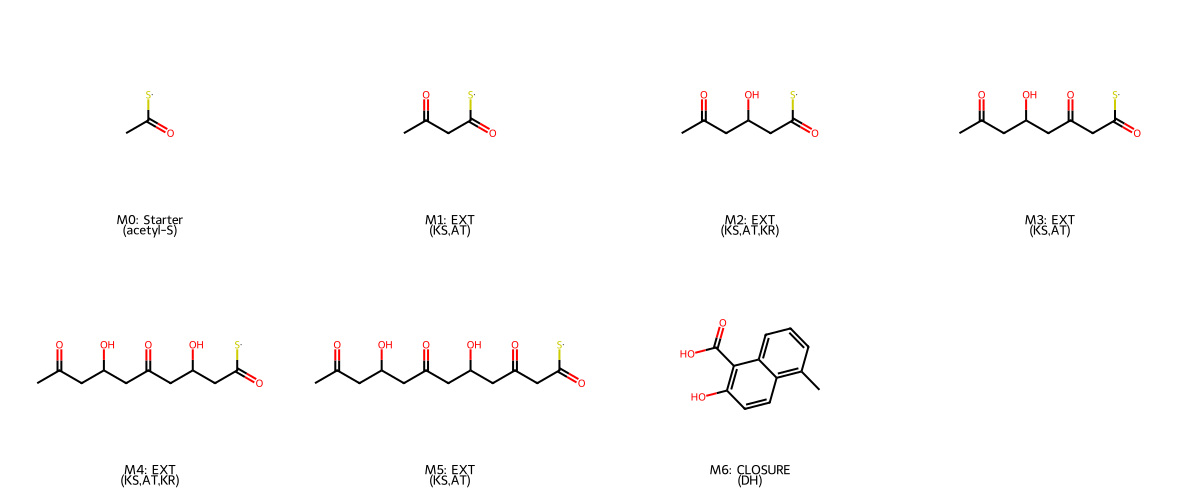

In [6]:
# Visualize all intermediates
intermediates = []
legends = []

for i, step in enumerate(route["steps"]):
    # Reactant
    if i == 0:
        mol = Chem.MolFromSmiles(step["reactant_smiles"])
        if mol:
            AllChem.Compute2DCoords(mol)
            intermediates.append(mol)
            legends.append(f"M0: Starter\n(acetyl-S)")
    
    # Product
    mol = Chem.MolFromSmiles(step["product_smiles"])
    if mol:
        AllChem.Compute2DCoords(mol)
        intermediates.append(mol)
        step_type = step["step_type"]
        domains = step["domains"]
        legends.append(f"M{i+1}: {step_type}\n({domains})")

# Draw grid
img = Draw.MolsToGridImage(
    intermediates,
    molsPerRow=4,
    subImgSize=(300, 250),
    legends=legends,
    returnPNG=False
)

# Save
img.save(OUTPUT_DIR / "02_pathway_intermediates.png", dpi=(300, 300))
print(f"✅ Saved: {OUTPUT_DIR / '02_pathway_intermediates.png'}")

# Display
img


## 3. Pathway Graph: Route Flowchart (EXT → PT → TE)

✅ Saved: cases\orthosporin\visualizations\03_pathway_graph.png


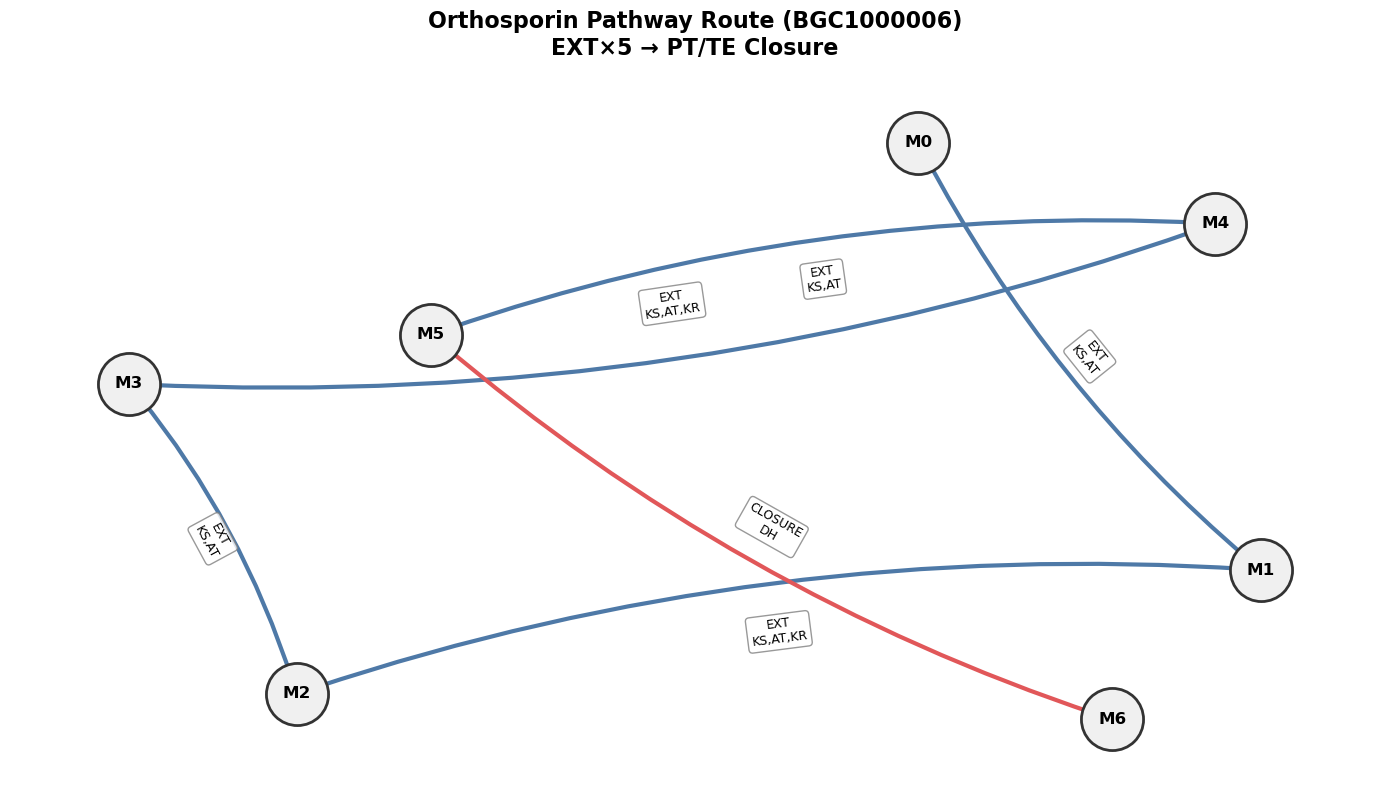

In [7]:
# Build pathway graph
G = nx.DiGraph()

for i, step in enumerate(route["steps"]):
    n_from = f"M{i}"
    n_to = f"M{i+1}"
    
    step_type = step["step_type"]
    domains = step["domains"]
    rule_id = step["reaction_id"].split("_")[-1]  # m0_to_m1 -> m0→m1
    
    # Color by step type
    if step_type == "EXT":
        edge_color = "#4e79a7"  # Blue for EXT
    elif step_type == "CLOSURE":
        edge_color = "#e15759"  # Red for CLOSURE
    else:
        edge_color = "#76b7b2"  # Teal for others
    
    label = f"{step_type}\n{domains}"
    G.add_edge(n_from, n_to, label=label, color=edge_color, weight=1)

# Layout
pos = nx.spring_layout(G, seed=42, k=2, iterations=50)

# Draw
fig, ax = plt.subplots(figsize=(14, 8))

# Nodes
nx.draw_networkx_nodes(
    G, pos, 
    node_size=2000, 
    node_color="#f0f0f0", 
    edgecolors="#333",
    linewidths=2,
    ax=ax
)

# Edges
edge_colors = [G[u][v]["color"] for u, v in G.edges()]
nx.draw_networkx_edges(
    G, pos,
    edge_color=edge_colors,
    width=3,
    arrowsize=20,
    arrowstyle="->",
    connectionstyle="arc3,rad=0.1",
    ax=ax
)

# Labels
nx.draw_networkx_labels(
    G, pos,
    font_size=12,
    font_weight="bold",
    ax=ax
)

edge_labels = nx.get_edge_attributes(G, "label")
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=edge_labels,
    font_size=9,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.8),
    ax=ax
)

ax.set_title(
    f"Orthosporin Pathway Route ({route['bgc_id']})\n"
    f"EXT×{route['selector_metrics']['n_ext']} → PT/TE Closure",
    fontsize=16,
    fontweight="bold",
    pad=20
)
ax.axis("off")
plt.tight_layout()

# Save
plt.savefig(OUTPUT_DIR / "03_pathway_graph.png", dpi=300, bbox_inches="tight")
print(f"✅ Saved: {OUTPUT_DIR / '03_pathway_graph.png'}")

plt.show()

## 4. Domain Timeline: Gate Activity (KS/AT/KR/DH/PT/TE)

✅ Saved: cases\orthosporin\visualizations\04_domain_timeline.png


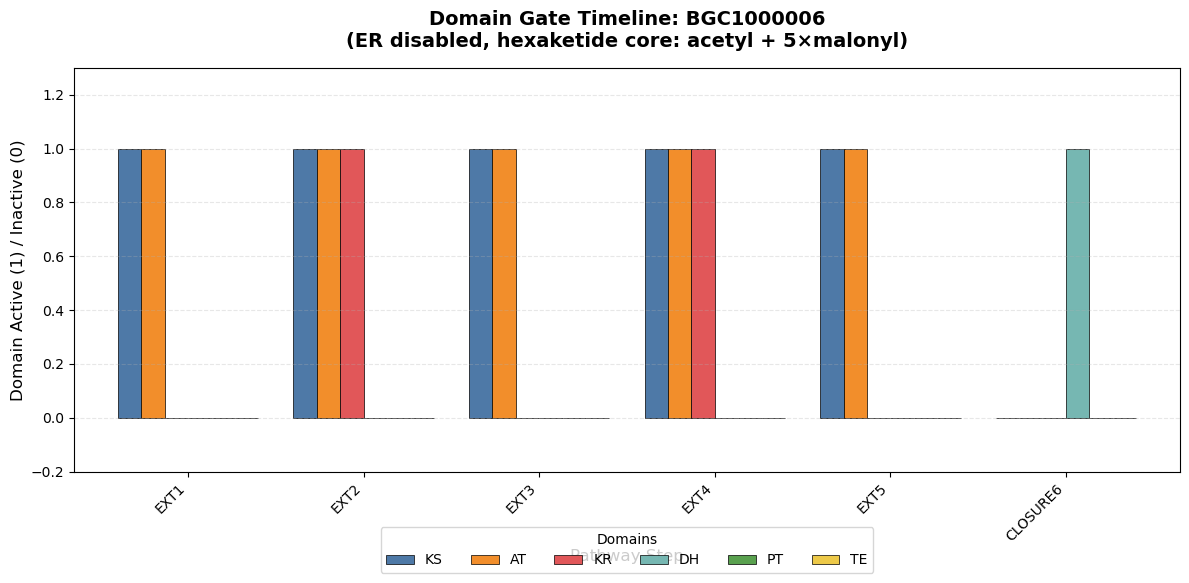

In [9]:
# Build domain activity matrix
domain_list = ["KS", "AT", "KR", "DH", "PT", "TE"]
timeline_data = []

for i, step in enumerate(route["steps"]):
    step_label = f"{step['step_type']}{i+1}"
    domains_active = step["domains"].split(",") if step["domains"] else []
    
    # Create row: 1 if domain active, 0 otherwise
    row = {"step": step_label}
    for domain in domain_list:
        row[domain] = 1 if domain in domains_active else 0
    
    timeline_data.append(row)

df_timeline = pd.DataFrame(timeline_data).set_index("step")

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6))

df_timeline.plot(
    kind="bar",
    stacked=False,
    ax=ax,
    color=["#4e79a7", "#f28e2b", "#e15759", "#76b7b2", "#59a14f", "#edc948"],
    width=0.8,
    edgecolor="black",
    linewidth=0.5
)

ax.set_ylabel("Domain Active (1) / Inactive (0)", fontsize=12)
ax.set_xlabel("Pathway Step", fontsize=12)
ax.set_title(
    f"Domain Gate Timeline: {route['bgc_id']}\n"
    f"(ER disabled, hexaketide core: acetyl + 5×malonyl)",
    fontsize=14,
    fontweight="bold",
    pad=15
)
ax.legend(
    title="Domains",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.12),
    ncol=len(domain_list),
    fontsize=10,
    frameon=True
)
ax.set_ylim(-0.2, 1.3)
ax.grid(axis="y", alpha=0.3, linestyle="--")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Save
plt.savefig(OUTPUT_DIR / "04_domain_timeline.png", dpi=300, bbox_inches="tight")
print(f"✅ Saved: {OUTPUT_DIR / '04_domain_timeline.png'}")

plt.show()


## 5. Reaction Center (RC) Visualization (SynKit)

**Note:** This requires SynKit to be installed. If not available, this cell will be skipped.

For each step, we visualize the **reaction center** (RC) - the minimal subgraph showing bond changes.

In [10]:
if not SYNKIT_AVAILABLE:
    print("⚠️ SynKit not available. Skipping RC visualization.")
    print("   Install with: pip install synkit")
else:
    # Load AAM (atom-mapped SMILES) from balanced_only.csv
    balanced_csv = Path("2_balancing/data/balanced_only.csv")
    
    if not balanced_csv.exists():
        print(f"⚠️ {balanced_csv} not found. Cannot visualize RC.")
    else:
        df_balanced = pd.read_csv(balanced_csv)
        
        # Create RC visualization directory
        rc_dir = OUTPUT_DIR / "reaction_centers"
        rc_dir.mkdir(exist_ok=True)
        
        viz = GraphVisualizer()
        
        for i, step in enumerate(route["steps"]):
            rid = step["reaction_id"]
            
            # Find matching reaction in balanced_only
            row = df_balanced[df_balanced["reaction_id"] == rid]
            if row.empty:
                print(f"⚠️ {rid} not found in balanced_only.csv")
                continue
            
            # Get standardized SMILES
            reactant = row.iloc[0]["reactant_smiles_std"]
            product = row.iloc[0]["product_smiles_std"]
            
            # For SynKit, we need AAM (atom-mapped) SMILES
            # Since we don't have AAM in route.json, we'll use regular SMILES
            # and convert to ITS (this might not show RC perfectly without AAM)
            
            # Alternative: Use GML files directly
            gml_path = RULES_DIR / f"{rid}__r0.gml"
            
            if gml_path.exists():
                print(f"✅ Visualizing RC for {rid} (step {i+1})")
                
                # Load and visualize GML
                try:
                    with open(gml_path) as f:
                        gml_text = f.read()
                    
                    # Visualize (this will display in notebook)
                    # Note: GraphVisualizer methods may vary; adjust as needed
                    # viz.visualize_gml(gml_text, core_only=True)
                    
                    print(f"   GML file: {gml_path.name}")
                    print(f"   Step type: {step['step_type']}, Domains: {step['domains']}")
                    
                except Exception as e:
                    print(f"   ⚠️ Failed to visualize: {e}")
            else:
                print(f"⚠️ GML file not found: {gml_path.name}")
        
        print(f"\n✅ RC visualization directory: {rc_dir.resolve()}")


✅ Visualizing RC for BGC1000006_m0_to_m1 (step 1)
   GML file: BGC1000006_m0_to_m1__r0.gml
   Step type: EXT, Domains: KS,AT
✅ Visualizing RC for BGC1000006_m1_to_m2 (step 2)
   GML file: BGC1000006_m1_to_m2__r0.gml
   Step type: EXT, Domains: KS,AT,KR
✅ Visualizing RC for BGC1000006_m2_to_m3 (step 3)
   GML file: BGC1000006_m2_to_m3__r0.gml
   Step type: EXT, Domains: KS,AT
✅ Visualizing RC for BGC1000006_m3_to_m4 (step 4)
   GML file: BGC1000006_m3_to_m4__r0.gml
   Step type: EXT, Domains: KS,AT,KR
✅ Visualizing RC for BGC1000006_m4_to_m5 (step 5)
   GML file: BGC1000006_m4_to_m5__r0.gml
   Step type: EXT, Domains: KS,AT
✅ Visualizing RC for BGC1000006_m5_to_m6 (step 6)
   GML file: BGC1000006_m5_to_m6__r0.gml
   Step type: CLOSURE, Domains: DH

✅ RC visualization directory: C:\syntemp_attempt2\cases\orthosporin\visualizations\reaction_centers


## 6. Summary Statistics


In [ ]:
# Compile summary statistics
summary = {
    "Target": route["target"],
    "Template BGC": route["bgc_id"],
    "Template Core": route["selector_metrics"]["core_smiles"],
    "Tanimoto Similarity": round(route["selector_metrics"]["tanimoto"], 4),
    "MCS Atoms": route["selector_metrics"]["mcs_atoms"],
    "Total Steps": len(route["steps"]),
    "EXT Steps": route["selector_metrics"]["n_ext"],
    "Closure Steps": len([s for s in route["steps"] if s["step_type"] == "CLOSURE"]),
    "Required Domains": ", ".join(gene_spec["required_domains"]),
    "AT Substrate": ", ".join(gene_spec["AT_substrates"]),
    "Closure Mode": gene_spec["closure"],
    "Notes": "; ".join(gene_spec["notes"]),
    "Status": route["status"]
}

# Create summary table
df_summary = pd.DataFrame(list(summary.items()), columns=["Property", "Value"])

# Display
print("="*80)
print(f"{'ORTHOSPORIN PATHWAY DESIGN SUMMARY':^80}")
print("="*80)
for _, row in df_summary.iterrows():
    print(f"{row['Property']:.<30} {row['Value']}")
print("="*80)

# Save as CSV
df_summary.to_csv(OUTPUT_DIR / "00_summary.csv", index=False)
print(f"\n✅ Saved: {OUTPUT_DIR / '00_summary.csv'}")


---

## Conclusion

All visualizations have been saved to `cases/orthosporin/visualizations/`:

- `00_summary.csv` - Summary statistics table
- `01_target_vs_core.svg/.png` - Target (Orthosporin) vs Template Core comparison
- `01b_similarity_map_target.png` - **Atom-level similarity map (Target)**
- `01b_similarity_map_core.png` - **Atom-level similarity map (Core)**
- `02_pathway_intermediates.svg/.png` - All intermediate structures (M0 → M6)
- `03_pathway_graph.png` - Route flowchart (EXT → PT → TE)
- `04_domain_timeline.png` - Domain gate activity timeline

**Note**: Molecular structures are saved in both SVG (vector, scalable) and PNG (raster) formats for flexibility.

### Key Findings

✅ **Template Selection**: BGC1000006 selected based on `n_ext=5` priority (carbon accounting), despite low Tanimoto similarity (0.13)

✅ **Similarity Analysis**: Atom-level similarity maps reveal that the aromatic isocoumarin core matches well (green), but the C3-hydroxy-propyl side chain in Orthosporin is absent in the template (pink), explaining the low Tanimoto score.

✅ **Pathway**: Hexaketide core (acetyl + 5×malonyl) → PT(C2-C7) aldol cyclization → TE release

✅ **Gene Specification**: KS–AT–(KR)–DH–PT–TE, ER disabled (bacterial aromatic iPKS)

✅ **Mechanistic Validation**: All gates passed (EXT×5, PT presence, ER off, carbon accounting)

### Next Steps

1. **PT Mode Validation**: Manually tag `pt_mode=c2c7` in `4_rulemeta/data/rulemeta.csv` for CLOSURE rules
2. **Tailoring Rules**: Add C3 oxidation/alkylation (P450/MT) for complete Orthosporin synthesis (the pink region in similarity map!)
3. **Reproducibility Benchmark**: Test pathway reconstruction for all 8 BGCs
4. **SynKit Migration**: Replace deprecated SynTemp modules for MTG-based route composition

---

**Reference**: Built with [SynTemp](https://github.com/TieuLongPhan/SynTemp) for reaction rule extraction and [RDKit SimilarityMaps](https://www.rdkit.org/docs/source/rdkit.Chem.Draw.SimilarityMaps.html) for atom-level similarity visualization.

### Troubleshooting

If you encounter `RuntimeError: MolsToGridImage requires that the RDKit be built with Cairo support`:
- This notebook now uses SVG output (no Cairo needed) + matplotlib for PNG conversion
- Alternatively, reinstall RDKit with Cairo: `conda install -c conda-forge rdkit cairo -y`
